# Refitting WT binding energies from glucose data 

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [1]:
import sys
import numpy as np
import pandas as pd
import pystan
sys.path.insert(0, '../../')
import mwc.bayes
import mwc.stats
import mwc.viz
import altair as alt
import bokeh.io
alt.data_transformers.enable('json')
bokeh.io.output_notebook()
# %load_ext stanmagic

Loading BokehJS ...

I would like to be able to have reliable confidence intervals based on my glucose data. While using the energies determined by Hernan is valid, I would reather determine the binding energy myself since I have reliable repressor counts.  

In [2]:
# Load the compiled data set. 
fc_data = pd.read_csv('../../data/compiled_fold_change.csv')

# Load the fluctutations
fluct_data = pd.read_csv('../../data/compiled_fluctuations.csv') 

# Isolate glucose data. 
gluc_fc = fc_data[(fc_data['carbon']=='glucose') & (fc_data['strain']=='dilution')].copy()
gluc_fluct = fluct_data[(fluct_data['carbon']=='glucose')].copy()

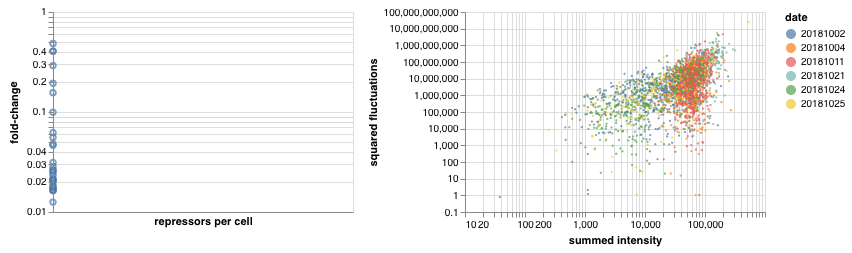

In [3]:
# Plot all glucose data. 
fc_points = alt.Chart(data=gluc_fc[gluc_fc['fold_change'] >= 0],
                     width=300, height=200).mark_point(
    ).encode(
        x=alt.X('mean_rep:Q', scale={'type':'log'}, axis={'title':'repressors per cell'}), 
        y=alt.Y('mean_fc:Q', scale={'type':'log'}, axis={'title':'fold-change'})
    ).transform_aggregate(
        mean_rep='mean(repressors)',
        mean_fc='mean(fold_change)',
        groupby=['atc_ngml','run_number', 'date'])

# Plot the fluctuation data. 
fluct_points = alt.Chart(data=gluc_fluct[(gluc_fluct['summed'] > 0) &
                                        (gluc_fluct['sq_fluct'] > 0)],
                         width=300, height=200
    ).mark_point(filled=True, size=5
    ).encode(
    x=alt.X('summed:Q', scale={'type':'log'}, axis={'title':'summed intensity'}),
    y=alt.Y('sq_fluct:Q', scale={'type':'log'}, axis={'title':'squared fluctuations'}),
    color='date:N') 

fc_points | fluct_points

In [4]:
# Load the stan model
model = pystan.StanModel('../stan/simultaneous_epRA_cal_factor.stan', include_paths='../stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_222f90995d24d4184176b4d29c8ded19 NOW.
/home/ec2-user/miniconda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmplqq0w9g6/stanfit4anon_model_222f90995d24d4184176b4d29c8ded19_5636289012734314387.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
# Add identifiers. 
gluc_fc = gluc_fc[gluc_fc['mean_mCherry'] >= 0].copy()
gluc_fc['conc_idx'] = gluc_fc.groupby(['atc_ngml']).ngroup() + 1
gluc_fc['run_idx'] = gluc_fc.groupby(['date', 'run_number']).ngroup() + 1
gluc_fc['conc_run_idx'] = gluc_fc.groupby(['date', 'run_number', 'atc_ngml']).ngroup() + 1
gluc_fluct['run_idx'] = gluc_fluct.groupby(['date', 'run_no']).ngroup() + 1
gluc_fc['tot_mCherry'] = gluc_fc['mean_mCherry'] * gluc_fc['area_pix']

# Group by the individual runs and compute the means. 
grouped = gluc_fc.groupby(['conc_run_idx']).mean().reset_index()

# Assemble the data dictionary. 
data_dict = {'J_conc': grouped['conc_idx'].max(),
            'J_runs': grouped['run_idx'].max(),
            'N_fluct':len(gluc_fluct),
            'N_fc':len(grouped),
            'fluct_index': gluc_fluct['run_idx'],
            'fc_index_run':grouped['run_idx'],
            'fc_index_conc':grouped['conc_idx'],
            'fc_index_replicates': grouped['conc_run_idx'],
            'I_1':gluc_fluct['I_1'],
            'I_2': gluc_fluct['I_2'],
            'mean_mCherry': grouped['tot_mCherry'],
            'fc': grouped['fold_change'],
            'Nns':4.6E6,
            'ep_AI':4.5}
# Sample!
samples = model.sampling(data=data_dict)

In [10]:
import bebi103
p = bebi103.viz.corner(samples.to_dataframe(),['alpha_mu', 'alpha_sigma', 'ep_RA', 'sigma'], datashade=False)
bokeh.io.show(p)

In [ ]:
print('hello')

In [6]:
!pip install bebi103

    100% |████████████████████████████████| 51kB 22.5MB/s 
    100% |████████████████████████████████| 1.3MB 28.6MB/s 
altair 2.2.2 requires typing, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


The goal here will be to simultaneously infer the calibration factor for each replicate of the glucose data and use that to infer the repressor copy number. The repressor copy number will then be used to infer the DNA binding energy. This becomes a somewhat complicated model, but should be easy to fit.  

In [4]:
# Add identifiers. 
gluc_fc = gluc_fc[gluc_fc['mean_mCherry'] >= 0].copy()
gluc_fc['conc_idx'] = gluc_fc.groupby(['atc_ngml']).ngroup() + 1
gluc_fc['run_idx'] = gluc_fc.groupby(['date', 'run_number']).ngroup() + 1
gluc_fc['conc_run_idx'] = gluc_fc.groupby(['date', 'run_number', 'atc_ngml']).ngroup() + 1
gluc_fluct['run_idx'] = gluc_fluct.groupby(['date', 'run_no']).ngroup() + 1
gluc_fc['tot_mcherry'] = gluc_fc['mean_mCherry'] * gluc_fc['area_pix']

# Assemble the data dictionary. 
data_dict = {'J_conc':gluc_fc['conc_idx'].max(),
            'J_runs':gluc_fc['run_idx'].max(),
            'J_conc_runs':gluc_fc['conc_run_idx'].max(),
            'N_fluct':len(gluc_fluct),
            'N_fc': len(gluc_fc),
            'fluct_index':gluc_fluct['run_idx'],
             'fc_index_run':gluc_fc['run_idx'],
            'fc_index_conc':[key[0] for key, value in gluc_fc.groupby(['conc_idx', 'conc_run_idx'])],
            'fc_conc_run_idx':gluc_fc['conc_run_idx'],
            'fc_index_replicates':gluc_fc['conc_run_idx'],
            'I_1': gluc_fluct['I_1'],
            'I_2': gluc_fluct['I_2'],
            'mCherry': gluc_fc['tot_mcherry'],
            'fc': gluc_fc['fold_change']}

# Load the stan model. 
# model = mwc.bayes.StanModel('../stan/simultaneous_epRA_cal_factor.stan', data_dict=data_dict)

# Reworking the inferential model

What I built above samples terribly slowly and with a huge number of divergences. I can rework it to be a bit simpler, I think, without sacrificing the error propagation I'm really after. First, let's think of the calculation of the repressor copy number per ATC concentration calculation. This is a simple hierarchical model of a set of repeated measurements, both technical and biological. This boils down to a case of computing the mean repressor copy number per experiment, which itself is drawn from a hyperparamter distribution. With the number of measurements I have for each replicate, however, it's not immediately obvious if this is necessary.  

To perform this comparison, we can infer the mean repressor copy number for a single concentration across all technical replicates and another across all technical replicates **and** all measurements. Below, I define two stan models that perform this inference

In [74]:
%%stan -v all_meas_hier
data {
    int<lower=1> J; // Number of replicates
    int<lower=1> N; // Number of measurements
    int<lower=1, upper=J> idx[N]; // Identification vector
    real<lower=0> R[N];
}

parameters {
    // Hyper parameters
    real<lower=0> log_R_1;
    real<lower=0> log_R_sigma_1;
    
    // Low-level uncentered parameters
    vector[J] log_R_2_raw;
    vector[J] log_R_sigma_2_raw;
    
    // How the hyperparameters vary
    real<lower=0>  tau_log_R;
    real<lower=0> tau_log_R_sigma;
}

transformed parameters {
    // Uncenter the low-level parameters. 
    vector[J] log_R_2 = log_R_1 + tau_log_R * log_R_2_raw;
    vector[J] log_R_sigma_2 = log_R_sigma_1 + tau_log_R_sigma * log_R_sigma_2_raw;
    real R_mu = exp(log_R_1);
    real R_sigma = exp(log_R_sigma_1);
    vector[J] R_2 = exp(log_R_2);
    vector[J] sigma = exp(log_R_sigma_2);
    
}

model {
    // Hyperpriors
    log_R_1 ~ normal(0, 2);
    log_R_sigma_1 ~ normal(0, 1);
   
    // Uncentering priors
    tau_log_R ~ normal(0, 1);
    tau_log_R_sigma ~ normal(0, 2);
    log_R_2_raw ~ normal(0, 1);
    log_R_sigma_2_raw ~ normal(0, 1);
    
    // Likelihood
    R ~ normal(R_2[idx], sigma[idx]);
}

generated quantities {
    real y_rep[N];
    for (i in 1:N) {
        y_rep[i] = normal_rng(R_mu, R_sigma);
    }
    
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in all_meas_hier object.
Type all_meas_hier in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^
Access model compile output properties
all_meas_hier.model_file -> Name of stan_file [None]
all_meas_hier.model_name -> Name of stan model [None]
all_meas_hier.model_code -> Model code [data {     int<lower ....]


In [75]:
%%stan -v simple_meas_hier
data {
    int<lower=1> N; // Number of measurements (of mean)
    real<lower=0> R[N];
}

parameters {
    real<lower=0> log_R_mu;
    real<lower=0> log_R_sigma; 
}

transformed parameters {
    real<lower=0> R_mu = exp(log_R_mu);
    real<lower=0> R_sigma = exp(log_R_sigma);
}
model {
    log_R_mu ~ normal(0, 4);
    log_R_sigma ~ normal(0, 2);     
    R ~ normal(R_mu, R_sigma);
}

generated quantities {
    real y_rep[N];
    for (i in 1:N) {
        y_rep[i] = normal_rng(R_mu, R_sigma);
    }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in simple_meas_hier object.
Type simple_meas_hier in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^^^^^
Access model compile output properties
simple_meas_hier.model_file -> Name of stan_file [None]
simple_meas_hier.model_name -> Name of stan model [None]
simple_meas_hier.model_code -> Model code [data {     int<lower ....]


In [ ]:
full_model = pystan.StanModel(model_code=all_meas_hier.model_code)
simple_model = pystan.StanModel(model_code=simple_meas_hier.model_code)

In [77]:
# assemble the data dictionaries. 
conc_test =gluc_fc[gluc_fc['atc_ngml'] == 10.0].copy()

# Divide by dummy value for simplicity
dummy_var = 400
conc_test['R'] = conc_test['tot_mcherry'] / dummy_var
conc_test['run_idx'] = conc_test.groupby(['run_number', 'date']).ngroup() + 1
simple_conc_test = conc_test.groupby(['run_idx']).mean().reset_index()
all_meas_data_dict = {'J': conc_test['run_idx'].max(),
                     'N':len(conc_test),
                     'idx': conc_test['run_idx'],
                     'R':conc_test['R']}
simple_meas_data_dict = {'N':len(simple_conc_test),
                   'R':simple_conc_test['R']}

full_samples = full_model.sampling(data=all_meas_data_dict, control={'adapt_delta':0.95, 'max_treedepth':12})
simple_samples = simple_model.sampling(data=simple_meas_data_dict, control={'adapt_delta':0.95, 'max_treedepth':12})

In [79]:
# Convert the samples to data frames
simple_df = simple_samples.to_dataframe()
full_df = full_samples.to_dataframe()

# Generate histograms of data sets 
hist, bins= np.histogram(simple_df['R_mu'], bins=50)
hist2, bins2 = np.histogram(full_df['R_mu'], bins=50)

# Generate the plot and format
p = bokeh.plotting.figure(width=400, height=400, 
                         x_axis_label='repressors per cell',
                         y_axis_label='samples')

p.step(bins[:-1], hist, legend='full dataset', line_width=2)
p.step(bins2[:-1], hist2, color='tomato', legend='aggregated means', line_width=2)
p.legend.location = 'top_right'
bokeh.io.show(p)


The resulting distributions are quite similar between the two methods, however using only the means reults in a borader posterior distribution. We can examine the posterior predictive checks of each model to see how well it matches the distributions

In [126]:
# Make plots of posterior predictive distributions
p1 = bebi103.viz.predictive_ecdf(full_samples, 
                                 'y_rep',
                                 data=conc_test['R'],
                                 diff=False,
                                 x_axis_label='repressors per cell (full data set)')
p2 = bebi103.viz.predictive_ecdf(simple_samples, 
                                 'y_rep',
                                 data=simple_conc_test['R'],
                                 diff=False,
                                 x_axis_label='repressors per cell (abbr data set)')
row = bokeh.layouts.Row(p1, p2)
bokeh.io.show(row)